# Compare the KdV model with measured near seabed velocity

In [93]:
from soda.dataio import netcdfio
from soda.dataio.conversion import readotps

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import h5py


In [2]:
%matplotlib notebook

In [3]:
# Load the station data
u1 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP_150','water_u')[0]
v1 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP_150','water_v')[0]

u2 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP150','water_u')[0]
v2 = netcdfio.load_sql_ncstation('/home/suntans/Share/database/UWAOceanDynamics.sqlite','KP150','water_v')[0]

u = xr.concat([u1,u2], dim='time')
v = xr.concat([v1,v2], dim='time')


Querying database...
LOWER(Variable_Name) LIKE LOWER("water_u") and StationName LIKE "%KP_150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0017
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0018
Querying database...
LOWER(Variable_Name) LIKE LOWER("water_v") and StationName LIKE "%KP_150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0017
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP_150_0018
Querying database...
LOWER(Variable_Name) LIKE LOWER("water_u") and StationName LIKE "%KP150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP150_0004
Querying database...
LOWER(Variable_Name) LIKE LOWER("water_v") and StationName LIKE "%KP150%"
/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/RPS_Shell_Crux_20162017.nc KP150_0004


<IPython.core.display.Javascript object>


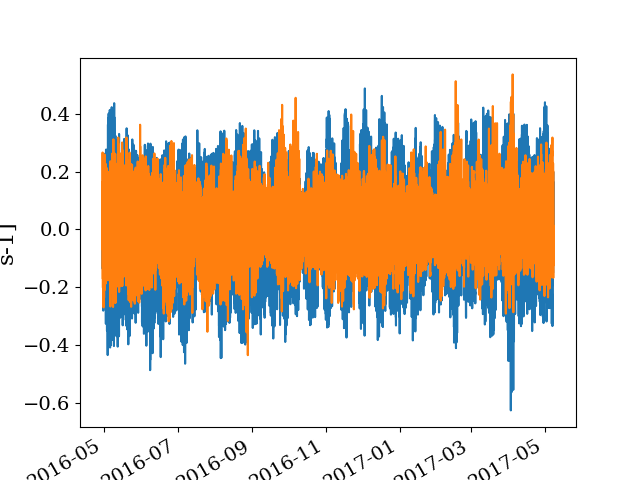

123.346383 -13.75895


In [4]:
u.plot()

v.plot()
print(u1.X, u1.Y)

<IPython.core.display.Javascript object>


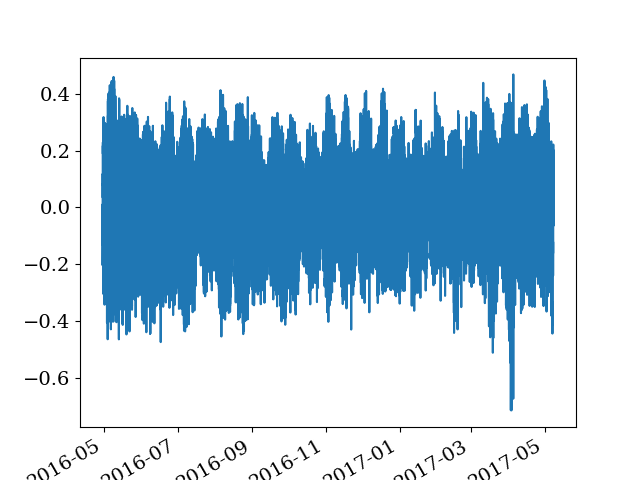

In [5]:
# Rotate the velocity +45 degrees CCW
def rotate_uv(u,v,wangle):

    ui = u+1j*v

    mag = np.abs(ui)
    ang = np.angle(ui)

    ur = mag*np.cos(ang+wangle)
    vr = mag*np.sin(ang+wangle)
    return ur,vr

wangle = 30*np.pi/180.
ur,vr = rotate_uv(u,v,wangle)
plt.figure()
ur.plot()





In [6]:
# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'

eta, ubar,vbar = readotps.tide_pred(tidemod, np.array([u1.X]), np.array([u1.Y]), u.time.values)

Interpolating consituent: M2...


/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: invalid value encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:328: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_im /= depth
/home/sun

Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


<IPython.core.display.Javascript object>


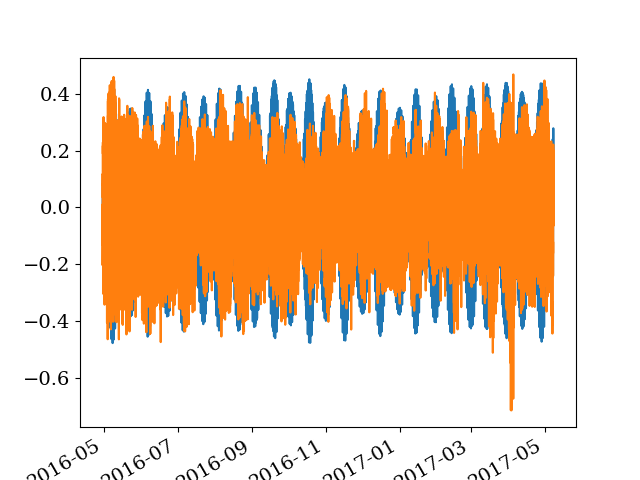

In [13]:
ubar_r, vbar_r = rotate_uv(ubar,vbar,wangle)
plt.figure()
plt.plot(u.time.values, ubar_r)
ur.plot()

<IPython.core.display.Javascript object>


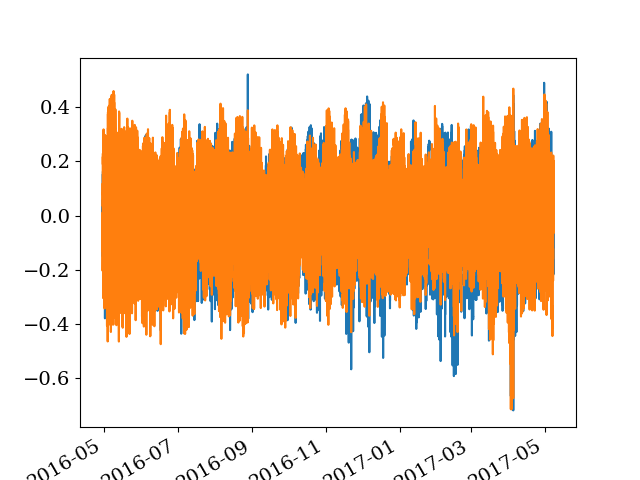

In [14]:
# Calculate the baroclinic velocity
ubc = ur.values-ubar_r.ravel()
plt.figure()
plt.plot(u.time.values,ubc)
ur.plot()

In [54]:
def maximum_amplitude_finder_old(amp_signal):
    amp_min = min(amp_signal)
    amp_max = max(amp_signal)
    if abs(amp_min)>amp_max:
        return amp_min
    else:
        return amp_max
    
def maximum_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    amp_max = np.nanmax(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        print(amp_max)
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

In [55]:
# Create a time series of single days with the max amplitude 
time1 = pd.date_range('2016-5-1','2016-9-15') 
time2 = pd.date_range('2016-11-1','2017-5-1')
timemax = time1.append(time2)

ds_Ubc = xr.DataArray(ubc, coords={'time':u.time.values}, dims=('time',))

Umax_all = []
Umax_time = []
for t1 in timemax:
    t2 = t1 + np.timedelta64(1,'D')
    print(t1,t2)
    Umax, tidx = maximum_amplitude_finder(ds_Ubc.sel(time=slice(t1,t2)).values)
    tmax = ds_Ubc.sel(time=slice(t1,t2)).time[tidx].values
    Umax_all.append(Umax)
    Umax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_U = xr.DataArray(Umax_all, coords={'time':Umax_time}, dims=('time',))

2016-05-01 00:00:00 2016-05-02 00:00:00
2016-05-02 00:00:00 2016-05-03 00:00:00
2016-05-03 00:00:00 2016-05-04 00:00:00
2016-05-04 00:00:00 2016-05-05 00:00:00
0.1832183350615387
2016-05-05 00:00:00 2016-05-06 00:00:00
0.2521390447125166
2016-05-06 00:00:00 2016-05-07 00:00:00
2016-05-07 00:00:00 2016-05-08 00:00:00
2016-05-08 00:00:00 2016-05-09 00:00:00
2016-05-09 00:00:00 2016-05-10 00:00:00
2016-05-10 00:00:00 2016-05-11 00:00:00
0.3225988316668874
2016-05-11 00:00:00 2016-05-12 00:00:00
2016-05-12 00:00:00 2016-05-13 00:00:00
2016-05-13 00:00:00 2016-05-14 00:00:00
2016-05-14 00:00:00 2016-05-15 00:00:00
2016-05-15 00:00:00 2016-05-16 00:00:00
2016-05-16 00:00:00 2016-05-17 00:00:00
2016-05-17 00:00:00 2016-05-18 00:00:00
0.26354565122961165
2016-05-18 00:00:00 2016-05-19 00:00:00
0.29740956906517546
2016-05-19 00:00:00 2016-05-20 00:00:00
0.27120735684062264
2016-05-20 00:00:00 2016-05-21 00:00:00
0.23792931297053954
2016-05-21 00:00:00 2016-05-22 00:00:00
2016-05-22 00:00:00 201

2016-12-12 00:00:00 2016-12-13 00:00:00
0.3053327119251674
2016-12-13 00:00:00 2016-12-14 00:00:00
2016-12-14 00:00:00 2016-12-15 00:00:00
0.32665782753615547
2016-12-15 00:00:00 2016-12-16 00:00:00
2016-12-16 00:00:00 2016-12-17 00:00:00
2016-12-17 00:00:00 2016-12-18 00:00:00
2016-12-18 00:00:00 2016-12-19 00:00:00
2016-12-19 00:00:00 2016-12-20 00:00:00
2016-12-20 00:00:00 2016-12-21 00:00:00
2016-12-21 00:00:00 2016-12-22 00:00:00
0.3219229033825889
2016-12-22 00:00:00 2016-12-23 00:00:00
2016-12-23 00:00:00 2016-12-24 00:00:00
2016-12-24 00:00:00 2016-12-25 00:00:00
2016-12-25 00:00:00 2016-12-26 00:00:00
0.21914780728255237
2016-12-26 00:00:00 2016-12-27 00:00:00
0.2387560694620629
2016-12-27 00:00:00 2016-12-28 00:00:00
0.17816593673862835
2016-12-28 00:00:00 2016-12-29 00:00:00
0.16061409203344557
2016-12-29 00:00:00 2016-12-30 00:00:00
0.22778275309349172
2016-12-30 00:00:00 2016-12-31 00:00:00
2016-12-31 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2017-01-02 00:00:00
0.2

<IPython.core.display.Javascript object>


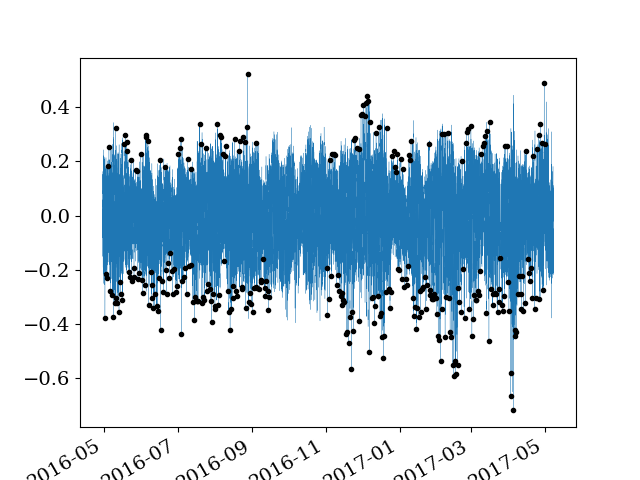

In [56]:
plt.figure()
ds_Ubc.plot(lw=0.2)
plt.plot(ds_U['time'], ds_U.values,'k.')

In [104]:
# Load up the kdv solution
#dskdv = xr.open_dataset('../output/kdv_magnus_x100km_v2.nc')
#dskdv = xr.open_dataset('../output/2019-07-03--06-58-08_magnus_kdv_runs.nc')
#dskdv = xr.open_dataset('../output/2019-07-15--11-53-58_magnus_kdv_runs.nc') #KdV w/ new a0
#dskdv = xr.open_dataset('../output/magnus_kdv_runs_vi_beta_new_a0.nc')
dskdv = xr.open_dataset('../output/magnus_kdv_runs_vi_beta_lag_a0.nc')


dskdv



<xarray.Dataset>
Dimensions:    (ensemble: 500, params: 6, time: 374)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 366 367 368 369 370 371 372 373
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params     (params) int64 0 1 2 3 4 5
Data variables:
    amax       (ensemble, time) float64 ...
    tmax       (ensemble, time) float64 ...
    a0         (ensemble, time) float64 ...
    cn         (ensemble, time) float64 ...
    alpha      (ensemble, time) float64 ...
    alpha2     (ensemble, time) float64 ...
    cn_mu      (ensemble, time) float64 ...
    alpha_mu   (ensemble, time) float64 ...
    alpha2_mu  (ensemble, time) float64 ...
    beta       (time, ensemble, params) float64 ...
    ubed       (ensemble, time) float64 ...
    usurf      (ensemble, time) float64 ...

In [105]:
badidx = dskdv.amax==-999.
dskdv.amax.values[badidx] = np.nan
dskdv.ubed.values[badidx] = np.nan

In [106]:
# Get the time from the input beta file
#betafile = '../inputs/ShellCrux_Filtered_Density_BHM_VI_20162017.h5'
betafile = '../inputs/ShellCrux_Uniltered_Density_BHM_VI_20162017.h5'

timedays = dskdv.time
nt = timedays.shape[0]

# Get the time from the beta file
with h5py.File(betafile,'r') as f:
    t=f['data/time'][:].astype('<M8[ns]')
time = t[:nt]
#nt = time.shape[0]


#dskdv = dskdv.sel(time=range(nt))
#ds,nt

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 3 results
  r = func(a, **kwargs)


<IPython.core.display.Javascript object>


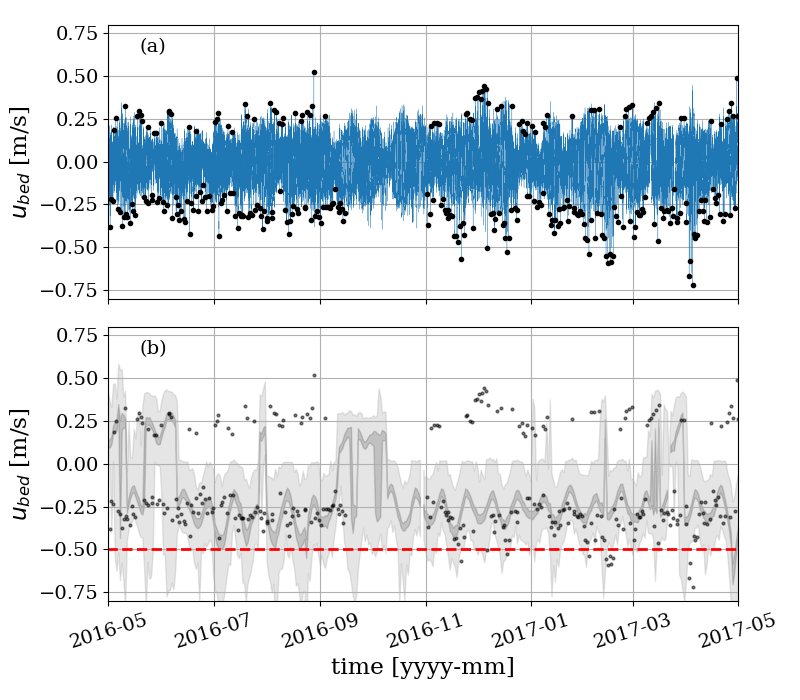

In [119]:
ubed_min = dskdv.ubed.min(axis=0)
ubed_max = dskdv.ubed.max(axis=0)
#ubed_min = np.percentile(dskdv.ubed,0.5, axis=0)
#ubed_max = np.percentile(dskdv.ubed,99.5, axis=0)
ubed_low = np.percentile(dskdv.ubed,25, axis=0)
ubed_high = np.percentile(dskdv.ubed,50, axis=0)
ubed_50 = np.median(dskdv.ubed, axis=0)


usurf_min = dskdv.usurf.min(axis=0)
usurf_max = dskdv.usurf.max(axis=0)
usurf_50 = np.mean(dskdv.usurf, axis=0)

xlim = [timemax[0],timemax[-1]]

plt.figure(figsize=(8,7))
ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
ds_Ubc.plot(lw=0.2)
plt.plot(ds_U['time'], ds_U.values,'k.')
xlim = [timemax[0],timemax[-1]]
ax1.set_xticklabels([])
plt.ylim(-0.8,0.8)
plt.xlabel('')
plt.grid(b=True)
plt.ylabel('$u_{bed}$ [m/s]')
plt.xlim(xlim)
plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
plt.fill_between(time, ubed_min, ubed_max, color='0.5',alpha=0.2)
plt.fill_between(time, ubed_low, ubed_high, color='0.2',alpha=0.2)

#plt.plot(time,ubed_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_U['time'], ds_U.values,'ko', ms=2,alpha=0.5)
#plt.xlim(200,300)
plt.ylabel('$u_{bed}$ [m/s]')
plt.ylim(-0.8,0.8)
#plt.xlabel('time [days]')
xlim = [timemax[0],timemax[-1]]

plt.grid(b=True)
plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)

plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)
plt.xlim(xlim)
plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)

#plt.xlim(time[0],time[-1])
#plt.savefig('../FIGURES/kdv_12month_velocity_validation.png',dpi=150)
plt.xticks(rotation=17)
plt.tight_layout()
plt.show()

plt.savefig('../FIGURES/kdv_12month_ubed_validation.png',dpi=150)
plt.savefig('../FIGURES/kdv_12month_ubed_validation.pdf',dpi=150)

In [108]:
# Validate the amplitude also...
###########
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan



19.583694322027494
25.72580998236746
30.651346642648264
30.75618982713848
31.697622640556084
29.35351977696867
30.99937748511356
29.833360391238777
32.320780804170454
22.92983081148104
22.019031236384727
18.699463113714277
19.76939850795132
17.798523423813556
13.578762808737723
16.759459478670394
20.44419369991568
30.158629062098086
25.785820294168616
23.727546970138118
25.75905245482068
25.249490529802127
29.15211305613643
21.244214814369833
21.65235013888547
19.39844460675488
19.689125565100433
26.679049795218685
27.942194341223097
25.63686635792784
21.63766958438595
16.23722950557005
23.28553459989879
27.895475484131502
27.027066967228347
30.070368072810513
22.477870273019906
20.945649139681933
22.961573020692708
26.211656406627533
27.73695877764543
27.799237443546872
43.94926441094086
22.88171722238612
23.44418298950688
25.77661830254321
14.87753047348693
27.268752277719294
18.788552259773013
21.36902534724117
22.832331422907814
24.422722456008234
24.95873175011968
22.1096431597016

<IPython.core.display.Javascript object>


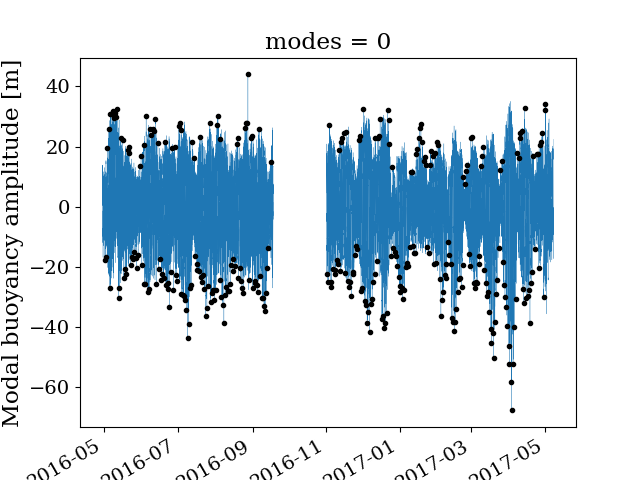

In [109]:
# Find the A_max over one day blocks


Amax_all = []
Amax_time = []
for t1 in timemax:
    t2 = t1 + np.timedelta64(1,'D')
    
    Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 3 results
  r = func(a, **kwargs)


<IPython.core.display.Javascript object>


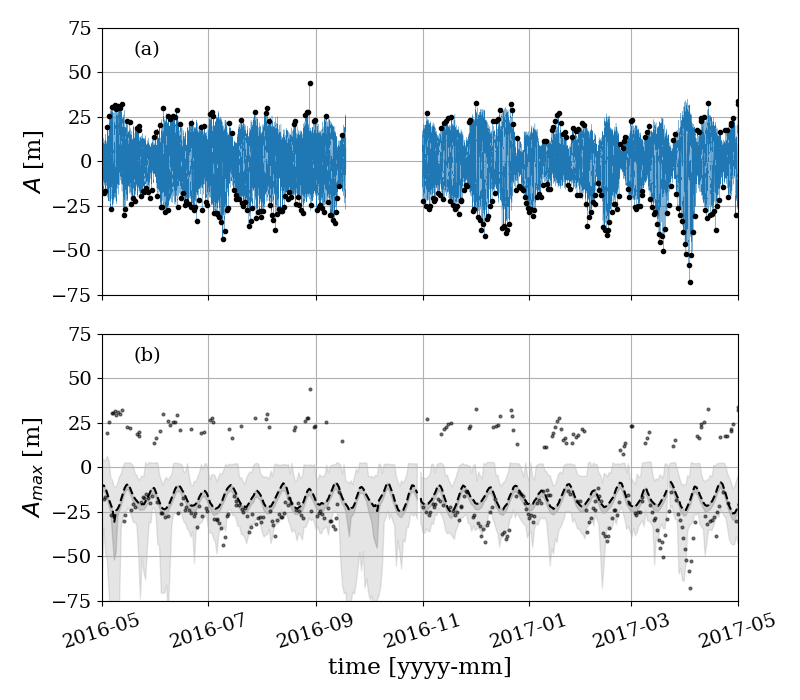

In [115]:
amax_min = np.percentile(dskdv.amax,0.5, axis=0)
amax_max = np.percentile(dskdv.amax,99.5, axis=0)
amax_low = np.percentile(dskdv.amax,25, axis=0)
amax_high = np.percentile(dskdv.amax,50, axis=0)
amax_amin = np.min(dskdv.amax, axis=0)
amax_amax = np.max(dskdv.amax, axis=0)
amax_50 = np.median(dskdv.amax, axis=0)

xlim = [timemax[0],timemax[-1]]
plt.figure(figsize=(8,7))

ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')
ax1.set_xticklabels([])
plt.xlabel('')
plt.grid(b=True)
plt.ylabel('$A$ [m]')
plt.ylim(-75,75)
plt.title('')
plt.xlim(xlim)
plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
plt.fill_between(time, amax_amin, amax_amax, color='0.5',alpha=0.2)
#plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)
#plt.xlim(200,300)
plt.ylabel('$A_{max}$ [m]')
plt.ylim(-75,75)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)

plt.xticks(rotation=17)
plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)

plt.tight_layout()
plt.show()
plt.savefig('../FIGURES/kdv_12month_Amax_validation.png',dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation.pdf',dpi=150)

<IPython.core.display.Javascript object>


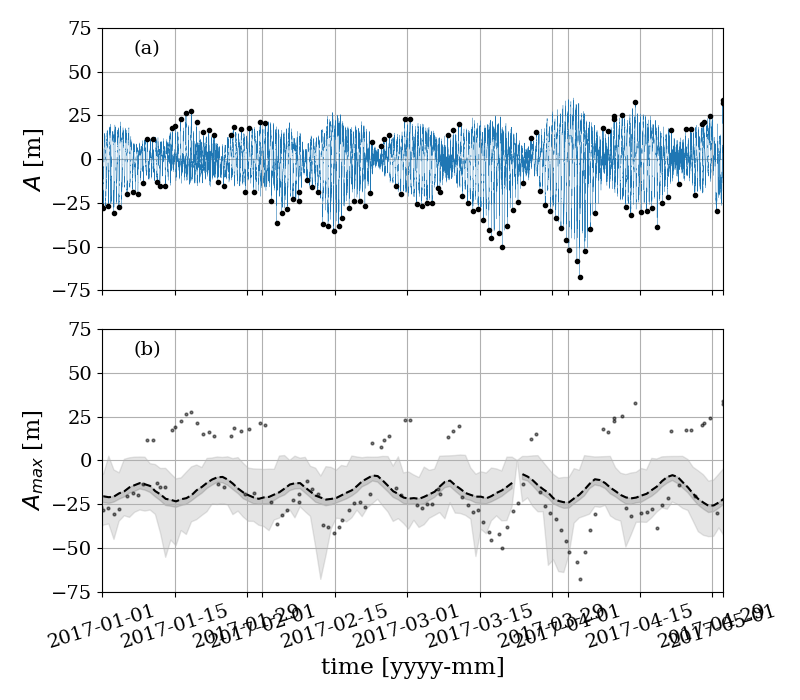

In [114]:
xlim = [datetime(2017,1,1),datetime(2017,5,1)]
plt.figure(figsize=(8,7))

ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')
ax1.set_xticklabels([])
plt.xlabel('')
plt.grid(b=True)
plt.ylabel('$A$ [m]')
plt.ylim(-75,75)
plt.title('')
plt.xlim(xlim)
plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
plt.fill_between(time, amax_amin, amax_amax, color='0.5',alpha=0.2)
#plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)
#plt.xlim(200,300)
plt.ylabel('$A_{max}$ [m]')
plt.ylim(-75,75)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)
#plt.xlim(time[0],time[-1])
plt.xticks(rotation=17)
plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)

plt.tight_layout()
plt.show()
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom.png',dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom.pdf',dpi=150)
